In [1]:
# Drop variables that don't seem to be contributing much of have problems
# (Wave 9 variables, high (anti-/)correlation variables, mostly not filled out, very low variance, too many categories)
# Transform variables (making some more easily readable
# and dummying non-ordinal categorical variables to create lots of new variables)
# rechecking if those new variables suffer from excessive levels of correlation

# Output: 
# BES_reduced - imputed dataset post-transformation
# BES_reduced_with_na - non-imputed dataset post-transformation


In [2]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import gc
import re

from itertools import cycle
from IPython.display import display
import pickle, os

import seaborn as sns

encoding = "ISO-8859-1"

import Jupyter_module_loader

from utility import *

In [3]:
# you should clone this git to this subdirectory (in some directory - I call it BES_analysis - doesn't matter though)

if os.getcwd().split(os.sep)[-1] != 'BES_analysis_code':
    raise Exception("Stop! You're in the wrong directory - should be in 'BES_analysis_code'")

BES_code_folder   = "../BES_analysis_code/" # we should be here!
BES_small_data_files = BES_code_folder + "small data files" + os.sep
if not os.path.exists( BES_small_data_files ):
    os.makedirs( BES_small_data_files )

# we should create these if they don't already exist
BES_data_folder   = "../BES_analysis_data/"
if not os.path.exists( BES_data_folder ):
    os.makedirs( BES_data_folder )

BES_output_folder = "../BES_analysis_output/"
if not os.path.exists( BES_output_folder ):
    os.makedirs( BES_output_folder )
    
BES_file_manifest = pd.read_csv( BES_small_data_files + "BES_file_manifest.csv" )

In [4]:
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [5]:
dataset_name = "W15_only"

In [6]:
%%time



manifest = BES_file_manifest[ BES_file_manifest["Name"] == dataset_name ]

data_subfolder = BES_data_folder + dataset_name + os.sep

filename = manifest["Stata_Filename"].values[0]

BES_Panel  = pd.read_msgpack(data_subfolder + filename.replace('.dta','.msgpack'))
print("BES_Panel", BES_Panel.shape )


BES_numeric = pd.read_msgpack( data_subfolder + "BESnumeric.msgpack" )
print("BES_numeric",  BES_numeric.shape )

try:
    var_type    = pd.read_csv( data_subfolder + "var_type.csv", encoding=encoding)
    var_type.set_index("Unnamed: 0", inplace=True)
except:
    var_type    = pd.read_hdf( data_subfolder + "var_type.hdf", encoding=encoding)
print("var_type",  var_type.shape )

fname = data_subfolder + "cat_dictionary.pkl"
with open(fname, "rb") as f:
    cat_dictionary = pickle.load( f )

BES_Panel (92587, 495)
BES_numeric (92587, 443)
var_type (495, 13)
Wall time: 1.29 s


In [7]:
%%time
# imputation_method = "mice" # "mice", "softimpute", "median", ???
# imputed_file_name = "BES" + imputation_method + wave

# imputation_method = "median" # "mice", "softimpute", "median", ???
# imputed_file_name = "BES" + imputation_method + wave


# BES_imputed = pd.read_hdf( BES_data_folder + imputed_file_name  + ".hdf", imputed_file_name )
BES_numeric.replace(-1,np.nan,inplace=True)
BES_imputed = BES_numeric.fillna(BES_numeric.median())
print("BES_imputed",  BES_imputed.shape )

BES_imputed (92587, 443)
Wall time: 595 ms


In [8]:
# England_inds = BES_Panel[BES_Panel["country"]=="England"].index
# print ( "respondents not from England: ", len(BES_Panel) - len(England_inds) )
# Remain_inds  = BES_Panel[ BES_Panel["euRefVote"].cat.codes==0 ].index
# Leave_inds   = BES_Panel[ BES_Panel["euRefVote"].cat.codes==1 ].index
# Notvoters_inds  = BES_Panel[ BES_Panel["euRefVote"].cat.codes==2 ].index
# Dontknow_inds   = BES_Panel[ BES_Panel["euRefVote"].cat.codes==3 ].index
# print ( "respondents not Remain/Leave: ", len(BES_Panel) - len(Remain_inds) - len(Leave_inds) )
# Leave_Remain_inds = pd.Index( np.concatenate( (Leave_inds, Remain_inds), axis=0 ) )
# EngRemLea_inds = pd.Index( np.intersect1d( England_inds, Leave_Remain_inds ) )

In [9]:
# W9_vars = pd.Index([x for x in BES_numeric.columns if "W9" in x])
# print ( "W9 columns: ", W9_vars )

In [10]:
# W9_vars = []

In [11]:
opts_per_cat = BES_numeric.apply(lambda x: len(pd.unique(x.dropna()))).sort_values()
many_cat_drop_list = opts_per_cat[opts_per_cat>60].index
# added to make sure we're only dropping *categorical* variables with lots of categories!
many_cat_drop_list = [x for x in var_type.loc[many_cat_drop_list].index
                      if var_type.loc[many_cat_drop_list].loc[x]["type"] in [3,7]]
print("many_cat_drop_list", many_cat_drop_list )

many_cat_drop_list ['profile_lea', 'profile_oslaua']


In [12]:
# %%time
# counts = BES_numerics_only[BES_num_and_cat["wave9"]==1 ].count()
# counts_by_individuals = BES_numerics_only[BES_num_and_cat["wave9"]==1 ].count(axis=1) # lets see
# f, axarr = plt.subplots( 2 ,figsize=(5, 5) )
# axarr[0].hist(counts,bins=50)
# axarr[1].hist(counts_by_individuals,bins=50)

In [13]:
# drop people who are coverage outliers
# say top and bottom 5%
# BES_red = BES_numerics_only.loc[BES_reduced["wave9"]==1 ].copy()

In [14]:
# thresh = .00
# BES_red = BES_numeric.copy()
# BES_red["coverage"] = BES_numeric.count(axis=1)/BES_numeric.shape[1]

# outlier_people = BES_red[( BES_red["coverage"]>BES_red["coverage"].quantile(1-thresh) ) | 
#                          ( BES_red["coverage"]<BES_red["coverage"].quantile(  thresh) ) ].index
# inlier_people  = BES_red[( BES_red["coverage"]<BES_red["coverage"].quantile(1-thresh) ) & 
#                          ( BES_red["coverage"]>BES_red["coverage"].quantile(  thresh) ) ].index

Wall time: 2.07 s


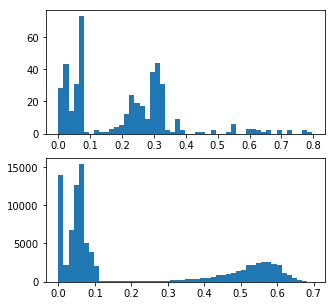

In [15]:
%%time
# columns histogrammed by %non-missing values
# rows histogrammed by %non-missing values

counts = BES_numeric.count()/BES_numeric.shape[0]
counts_by_individuals = BES_numeric.count(axis=1)/BES_numeric.shape[1] # lets see
f, axarr = plt.subplots( 2 ,figsize=(5, 5) )
ax = axarr[0].hist(counts,bins=50)
ax = axarr[1].hist(counts_by_individuals,bins=50)

In [16]:
# In theory, this is picked on the basis of looking at the above two diagrams (really, the top one!)
# thresh = 0.33
# missing_value_thresh = 0.33
missing_value_thresh = 0.05

mostly_not_filled_out = counts[counts<= (counts.max()*missing_value_thresh)].index
mostly_filled_out     = counts[counts>  (counts.max()*missing_value_thresh)].index

In [17]:
# missing_value_thresh = 0.8

# mostly_not_filled_out = counts[counts<= (counts.max()*missing_value_thresh)].index
# mostly_filled_out     = counts[counts>  (counts.max()*missing_value_thresh)].index

In [18]:
print(BES_numeric[mostly_filled_out].shape)
missing_fraction = BES_numeric[mostly_filled_out].isnull().sum().sum() / \
    (BES_numeric[mostly_filled_out].shape[0]*BES_numeric[mostly_filled_out].shape[1])
print(missing_fraction)

(92587, 366)
0.7603444428371342


In [19]:
# %%time
# frac=.2
# BES_numeric.sample(frac=frac).sample(frac=frac, axis=1).shape
# np.corrcoef( BES_numeric.sample(frac=frac).sample(frac=frac, axis=1) )
# BES_numeric.sample(frac=frac).sample(frac=frac, axis=1).corr(min_periods=100, method='pearson')



In [20]:
memory_use(locs = locals().items())

                   BES_numeric: 157.2MiB
                   BES_imputed: 157.2MiB
                     BES_Panel:  71.2MiB
         counts_by_individuals:   1.4MiB
                      var_type: 414.5KiB
                  opts_per_cat:  53.9KiB
                        counts:  53.9KiB
             BES_file_manifest:  45.6KiB
             mostly_filled_out:  25.2KiB
                cat_dictionary:  18.1KiB


In [21]:
%%time
# 0.05, 0.0025: 2.34
# 0.10, 0.01: 10.7s
# 0.10, spearman: 27s
# 0.10, kendall: 56s
# 0.15, 0.0225, pearson: 29s
# 0.20, 0.04, pearson: 65s
# 30 mins?
# W14_only: 55s
try:
    corr_mat = pd.read_msgpack(BES_data_folder+dataset_name+os.sep+"corr_df.msgpack")
except:
    corr_mat = BES_numeric.corr()
    corr_mat.to_msgpack(BES_data_folder+dataset_name+os.sep+"corr_df.msgpack")

Wall time: 50.8 s


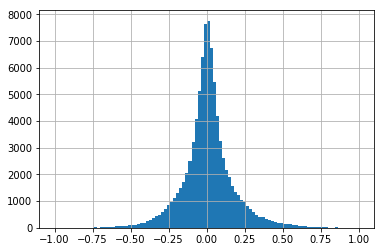

In [22]:
# %%time
## 5 minutes!
## 8h 41min 19s on W10_comb panel!

# data = BES_numeric
# corr_mat = BES_numeric.corr()

# create lower triangle - diag mask
col_vars = len( corr_mat )
df = pd.DataFrame( np.arange(col_vars*col_vars).reshape(col_vars,col_vars) )
mask = np.ones(df.shape,dtype='bool')
mask[np.triu_indices(len(df))] = False
corr_mat.mask(~mask).stack().hist(bins=100)

In [23]:
# build a data frame of pairs of highly corr/anti-corr variables
# score on correlation, %non-missing values for each
# Building the high_corr_list is still **manual** (not much reason to automate)


corr_df = pd.DataFrame(columns = ["var1","var2","corr","var1%","var2%","min var%"])

id_num = 0

# min_filled_out = 0.02
min_filled_out = 0.02

thresh = .05
x = ( ( corr_mat>(1-thresh) ) &mask ).values.nonzero()

for i in range( 0,len(x[0]) ):
    a = corr_mat.columns[ x[0][i] ]
    b = corr_mat.columns[ x[1][i] ]
    c = BES_numeric[a].notnull().mean()
    d = BES_numeric[b].notnull().mean()
    mincd = min(c,d)
    if mincd > min_filled_out:
        corr_df.loc[id_num] = [ a,b,corr_mat[a][b], c, d, mincd ]
        id_num = id_num + 1


x = ( ( corr_mat<(thresh-1) ) &mask ).values.nonzero()

for i in range( 0,len(x[0]) ):
    a = corr_mat.columns[ x[0][i] ]
    b = corr_mat.columns[ x[1][i] ]
    c = BES_numeric[a].notnull().mean()
    d = BES_numeric[b].notnull().mean()
    mincd = min(c,d)
    if (mincd > min_filled_out):
        corr_df.loc[id_num] = [ a,b,corr_mat[a][b], c, d, mincd ]
        id_num = id_num + 1

corr_df

,var1,var2,corr,var1%,var2%,min var%
0,pastvote_EURef,euRefpastVote,0.955400,0.296413,0.289533,0.289533
1,ageGroup,age,0.975375,0.718805,0.332995,0.332995
2,profile_turnout_2015,voted2015newwording,1.000000,0.631752,0.020446,0.020446
3,profile_eurefvote,pastvote_EURef,0.965105,0.529178,0.296413,0.296413
4,remainVnodeal,euRefVote,-0.954265,0.289436,0.295927,0.289436
5,scotRefID,scotReferendumIntention,-0.953412,0.029129,0.029378,0.029129


In [24]:
# corr_df.to_hdf(BES_data_folder+"corr_dfW10Panel.hdf","corr_dfW10Panel")


In [25]:
corr_df

,var1,var2,corr,var1%,var2%,min var%
0,pastvote_EURef,euRefpastVote,0.955400,0.296413,0.289533,0.289533
1,ageGroup,age,0.975375,0.718805,0.332995,0.332995
2,profile_turnout_2015,voted2015newwording,1.000000,0.631752,0.020446,0.020446
3,profile_eurefvote,pastvote_EURef,0.965105,0.529178,0.296413,0.296413
4,remainVnodeal,euRefVote,-0.954265,0.289436,0.295927,0.289436
5,scotRefID,scotReferendumIntention,-0.953412,0.029129,0.029378,0.029129


In [26]:
# corr_df = pd.read_hdf(BES_data_folder+"corr_dfW10Panel.hdf","corr_dfW10Panel")

In [27]:
corr_df.sort_values(by="min var%",ascending=False).head(70)

,var1,var2,corr,var1%,var2%,min var%
1,ageGroup,age,0.975375,0.718805,0.332995,0.332995
3,profile_eurefvote,pastvote_EURef,0.965105,0.529178,0.296413,0.296413
0,pastvote_EURef,euRefpastVote,0.955400,0.296413,0.289533,0.289533
4,remainVnodeal,euRefVote,-0.954265,0.289436,0.295927,0.289436
5,scotRefID,scotReferendumIntention,-0.953412,0.029129,0.029378,0.029129
2,profile_turnout_2015,voted2015newwording,1.000000,0.631752,0.020446,0.020446


In [28]:
corr_df[corr_df["min var%"]>missing_value_thresh]

,var1,var2,corr,var1%,var2%,min var%
0,pastvote_EURef,euRefpastVote,0.955400,0.296413,0.289533,0.289533
1,ageGroup,age,0.975375,0.718805,0.332995,0.332995
3,profile_eurefvote,pastvote_EURef,0.965105,0.529178,0.296413,0.296413
4,remainVnodeal,euRefVote,-0.954265,0.289436,0.295927,0.289436


In [29]:
corr_df

,var1,var2,corr,var1%,var2%,min var%
0,pastvote_EURef,euRefpastVote,0.955400,0.296413,0.289533,0.289533
1,ageGroup,age,0.975375,0.718805,0.332995,0.332995
2,profile_turnout_2015,voted2015newwording,1.000000,0.631752,0.020446,0.020446
3,profile_eurefvote,pastvote_EURef,0.965105,0.529178,0.296413,0.296413
4,remainVnodeal,euRefVote,-0.954265,0.289436,0.295927,0.289436
5,scotRefID,scotReferendumIntention,-0.953412,0.029129,0.029378,0.029129


In [30]:
np.linalg.matrix_rank(BES_imputed.values),BES_imputed.shape

C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\numpy\core\_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)
C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\numpy\linalg\linalg.py:1794: RuntimeWarning: invalid value encountered in greater
  return count_nonzero(S > tol, axis=-1)


(0, (92587, 443))

In [31]:
# BES_imputed.columns[ BES_imputed.isnull().all() ]

In [32]:
high_corr_drop_list = []

for ind in corr_df.index:
    if corr_df.loc[ind]["var1%"] == corr_df.loc[ind]["var2%"]: # prefer age over ageGroup
        options = set(corr_df.loc[ind][["var1" , "var2"]].values)
        if 'age' in options:
#             print(ind, list(options.difference(['age']))[0] )
            high_corr_drop_list.append( list(options.difference(['age']))[0] )
    elif corr_df.loc[ind]["var1%"] < corr_df.loc[ind]["var2%"]:
#         print(ind, corr_df.loc[ind]["var1"])
        high_corr_drop_list.append( corr_df.loc[ind]["var1"] )
    else:
#         print(ind, corr_df.loc[ind]["var2"])
        high_corr_drop_list.append( corr_df.loc[ind]["var2"] )
    
high_corr_drop_list = list( set(high_corr_drop_list) ) # make unique
high_corr_drop_list

['euRefpastVote',
 'scotRefID',
 'pastvote_EURef',
 'age',
 'voted2015newwording',
 'remainVnodeal']

In [33]:
# high_corr_drop_list = []

In [34]:
# pref_list ['age','euRefVote',]


# high_corr_drop_list = []

# if ('age' in BES_numeric.columns) and ('Age' in BES_numeric.columns):
#     high_corr_drop_list.extend('Age')
    
# if ('ageGroup' in BES_numeric.columns) and ('age' in BES_numeric.columns):
#     high_corr_drop_list.extend('ageGroup')
    
# if ('euRefVote' in BES_numeric.columns) and ('age' in BES_numeric.columns):
#     high_corr_drop_list.extend('ageGroup')    

# high_corr_drop_list.extend(['euRefVoteUnsqueeze', 'euRefVote2', 'euRefVotePost',
#                        'ageGroup', 'voted2015', "ns_sec" , 'recallVote15'])
# # # 
# # high_corr_drop_list = ['euRefVoteUnsqueeze', 'euRefVote2', 'euRefVotePost',
# #                        'ageGroup', 'Age', 'profile_turnout_2015', "ns_sec" , 'profile_past_vote_2015',"euIDW9"]

# # high_corr_drop_list = ["euID","ageGroup","euRefpastVote","voted2015"]

In [35]:
### HIGH CORR DROP LIST OVERRIDE
# high_corr_drop_list = []

Wall time: 226 ms


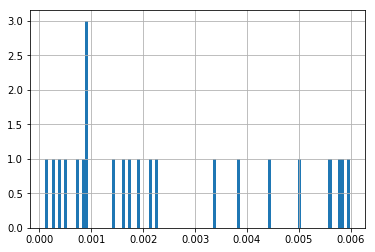

In [36]:
%%time
## TEST VARIANCES
a = BES_imputed.var()
b = a<a.quantile(.05)
a[b].hist(bins=100)
very_low_var = BES_imputed.columns[b]
# a.quantile(.01)

In [37]:
# drop columns below certain % filled out (2%)
# drop columns which are identical (drop least filled in) or directly derived
# make a list of derived columns??? -> scales

# WHAT TO REMOVE?
# W9_vars
# two_opt_cats
# many_cat_drop_list
# high_corr_drop_list
# mostly_not_filled_out
# mostly_filled_out

In [38]:
# very_low_var =[]

In [39]:
# mostly_not_filled_out =[]

In [40]:
# many_cat_drop_list =[]

In [41]:
gc.collect()

7638

In [42]:
# high_corr_drop_list = []

In [43]:
# high_corr_drop_list

In [44]:
high_corr_drop_list = []

In [45]:
# Time to dump some variables!
# (The results of this may have been exported back to the Imputation script
# if it looks like nothing is happening, that's why!)


BES_reduced = BES_imputed.copy()
cols = BES_reduced.columns
print(BES_reduced.shape)

# # Wave 9 stuff
# BES_reduced.drop(W9_vars,axis=1,errors='ignore',inplace=True)
# print("W9_vars", BES_reduced.shape)
# drop_cols = cols.difference(BES_reduced.columns)
# if ( (len(drop_cols) >0) and (len(drop_cols) <= 10) ): print(drop_cols) 
# cols = BES_reduced.columns

# Categorical variables with a huge number of categories
BES_reduced.drop(many_cat_drop_list,axis=1,errors='ignore',inplace=True)
print("many_cat_drop_list", BES_reduced.shape)
drop_cols = cols.difference(BES_reduced.columns)
if ( (len(drop_cols) >0) and (len(drop_cols) <= 10) ): print(drop_cols) 
cols = BES_reduced.columns

# Variables which are redundant through very high correlation with other variables
BES_reduced.drop(high_corr_drop_list,axis=1,errors='ignore',inplace=True)
print("high_corr_drop_list", BES_reduced.shape)
drop_cols = cols.difference(BES_reduced.columns)
if ( (len(drop_cols) >0) and (len(drop_cols) <= 10) ): print(drop_cols) 
cols = BES_reduced.columns

# Variables with 'too many' missing values
BES_reduced.drop(mostly_not_filled_out,axis=1,errors='ignore',inplace=True)
print("mostly_not_filled_out", BES_reduced.shape)
drop_cols = cols.difference(BES_reduced.columns)
if ( (len(drop_cols) >0) and (len(drop_cols) <= 10) ): print(drop_cols) 
cols = BES_reduced.columns

# Variables with 'too low' variance
BES_reduced.drop(very_low_var,axis=1,errors='ignore',inplace=True) 
print("very_low_var", BES_reduced.shape)
drop_cols = cols.difference(BES_reduced.columns)
if ( (len(drop_cols) >0) and (len(drop_cols) <= 10) ): print(drop_cols) 
cols = BES_reduced.columns

(92587, 443)
many_cat_drop_list (92587, 441)
Index(['profile_lea', 'profile_oslaua'], dtype='object')
high_corr_drop_list (92587, 441)
mostly_not_filled_out (92587, 364)
very_low_var (92587, 356)
Index(['RPrivSchnew_dk', 'achieveReduceImmigGrn', 'achieveReduceImmigLD',
       'achieveReduceImmigTIG', 'noDealEmotions_8', 'otherCitizen',
       'privPrimSchool', 'privSecondSchool'],
      dtype='object')


In [46]:
# necessary because some imputation types impute values outside of range of available values
# kind of suggests ... maybe not such good imputation methods??
def float_2_categorical(series,cat_dict):
    ser = series.astype('int')
    ser = ser.apply( lambda x : min( x , len( cat_dict ) - 1) )
    ser = ser.apply( lambda x : max( x , 0 ) )
    ser = ser.apply( lambda x: cat_dict[x] )  
    return ser

In [47]:
# problem
#  'xprofile_house_tenure': 'Own â\x80\x93 outright',

In [48]:
# reorder categories in a categorical variable so that the most numerous subcategory goes first
# so it can be dropped automatically when dummying
# also, return name of reference subcategory
def select_reference_subcategory(non_ordinal):
    order = BES_numeric[non_ordinal]\
        .dropna().astype('int').apply( lambda x: cat_dictionary[non_ordinal][x] ).value_counts().index
    return BES_reduced[non_ordinal].astype('category').cat.reorder_categories( order ), order[0]

In [49]:
# Recreate and rename categorical non_ordinal and ordinal variables:
# ordinal two categories -> one single dummy binary variable labelled with positive category name (e.g gender_female)
# ordinal 3+ category variables just renamed to append "__top_value" to variable name
# non-ordinal 3+ categories -> split to individual dummy binary variables "category_subcateory"

# need to create a dict of new_variable_names with old col names
# to allow reinsertion of missing values, say
new_old_col_names = dict()
# we need to drop one sub-category for each categorical variable we dummy
# advice supports obvious guess - always choose most numerous subcategory to the reference subcategory
non_ordinal_base_subcat = dict()


In [50]:
# NON-ORDINAL CATEGORICAL VARIABLES
# get split into one variable for each category
# NOTE: Dummy variable/multicollinearity trap
# we need to choose a base variable for each category and drop it!
drop_reference = False

non_ordinal_list = var_type[ var_type["type"]==3 ].index.intersection(BES_reduced.columns)
for non_ordinal in non_ordinal_list:
    # return to text categories!
    BES_reduced[non_ordinal] = float_2_categorical(BES_reduced[non_ordinal],
                                                   cat_dictionary[non_ordinal])
    # reorder to place most numerous subcategory first
    BES_reduced[non_ordinal], non_ordinal_base_subcat[non_ordinal] = \
        select_reference_subcategory( non_ordinal  )
    
    # create dictionary so we have a record of which variable all newly generated ones come from!
    for subcat in cat_dictionary[non_ordinal]:
        new_col_name = non_ordinal + "_" + subcat
        new_old_col_names[new_col_name] = non_ordinal

if drop_reference == True:
    BES_reduced = pd.get_dummies( BES_reduced, columns=non_ordinal_list, drop_first=True ) 
else:
    BES_reduced = pd.get_dummies( BES_reduced, columns=non_ordinal_list, drop_first=False )
    

In [51]:
# BINARY CATEGORICAL VARIABLES
# get renamed with 'top' value separated by single underscore
# (this is the same as with non-ordinal variables - maybe use a different convention - like ___)
# i.e. haveDependents -> haveDependents_No

two_opt_cats = opts_per_cat[opts_per_cat==2].index.intersection(BES_reduced.columns)
for col in two_opt_cats:
    BES_reduced[col] = BES_reduced[col]\
    .astype('int').apply( lambda x: cat_dictionary[col][x] )\
    .astype('category').cat.reorder_categories(cat_dictionary[col])
    
    new_col_name = col + "_" + cat_dictionary[col][1]
    new_old_col_names[new_col_name] = col
    
BES_reduced = pd.get_dummies( BES_reduced, columns=two_opt_cats, drop_first=True )

In [52]:
# ORDINAL CATEGORICAL VARIABLES
# get renamed with 'top' value separated by double underscore
# i.e. likeBoris -> likeBoris__Strongly Agree

ordinal_list = var_type[ var_type["type"].apply(lambda x: x in [1,2,5]) ].index.intersection(BES_reduced.columns)
for ordinal in ordinal_list:
    new_col_name = ordinal + "__" + (cat_dictionary[ordinal])[-1:][0]
    BES_reduced.rename(columns={ordinal:new_col_name}, inplace=True)
    new_old_col_names[new_col_name] = ordinal
    
print("BES_reduced",BES_reduced.shape)

BES_reduced (92587, 587)


In [53]:
gc.collect()

259

In [54]:
memory_use(locs = locals().items())

                   BES_numeric: 157.2MiB
                   BES_imputed: 157.2MiB
                   BES_reduced: 121.4MiB
                     BES_Panel:  71.2MiB
                      corr_mat:   1.5MiB
         counts_by_individuals:   1.4MiB
                            df: 766.7KiB
                      var_type: 414.5KiB
                          mask: 191.8KiB
                  opts_per_cat:  53.9KiB


In [55]:
del BES_imputed

In [56]:
%%time
## slow! 2h 47min 41s

# 4h 19min 35s!!!?


## We should do correlation testing on a version with missing values
## and may also wish an output with missing values (e.g. to run weightedPCA on)
## Which means reinserting missing values

BES_reduced_with_na = BES_reduced.copy()

for col in BES_reduced_with_na.columns:
    if col in new_old_col_names.keys():
        old_col = new_old_col_names[col]
        null_series = BES_numeric[old_col].isnull()
    else:
        null_series = BES_numeric[col].isnull()
        
    BES_reduced_with_na.loc[null_series,col] = np.nan
    
    # 2 option ordinal (name change)
    # 3+ option ordinal (name change)
    # categorical (split into lots of variables)
    # other (no name change)

Wall time: 56.4 s


In [57]:
# BES_reduced_with_na[col][~null_series]

In [58]:
## TEST CORRELATIONS
# we want to avoid having columns which are basically the same data
# through very high correlation/anti-correlation
# and when we find them, we want to keep the column with less missing values

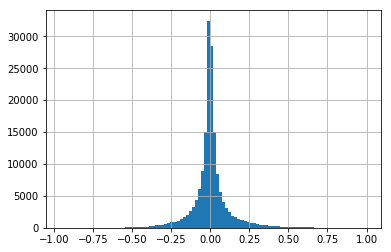

In [59]:
# data = BES_reduced_with_na
corr_mat = BES_reduced_with_na.corr()
# create lower triangle - diag mask
col_vars = len( corr_mat )
df = pd.DataFrame( np.arange(col_vars*col_vars).reshape(col_vars,col_vars) )
mask = np.ones(df.shape,dtype='bool')
mask[np.triu_indices(len(df))] = False
corr_mat.mask(~mask).stack().hist(bins=100)

In [60]:
thresh = .05
x = ( ( corr_mat>(1-thresh) ) & mask ).values.nonzero()

for i in range( 0,len(x[0]) ):
    a = corr_mat.columns[ x[0][i] ]
    b = corr_mat.columns[ x[1][i] ]
    print( ( a,b,corr_mat[a][b], BES_reduced_with_na[a].notnull().mean(), BES_reduced_with_na[b].notnull().mean() ) )

x = ( ( corr_mat<(thresh-1) ) & mask ).values.nonzero()

for i in range( 0,len(x[0]) ):
    a = corr_mat.columns[ x[0][i] ]
    b = corr_mat.columns[ x[1][i] ]
    print( ( a,b,corr_mat[a][b], BES_reduced_with_na[a].notnull().mean(), BES_reduced_with_na[b].notnull().mean() ) )    

('ageGroup__66+', 'age', 0.9753750858927815, 0.7188050158229558, 0.33299491289273875)
('generalElectionVoteTIG_Conservative', 'generalElectionVote_Conservative', 0.9647721554807317, 0.2208733407497813, 0.21711471372870922)
('generalElectionVoteTIG_Labour', 'generalElectionVote_Labour', 0.9598354450646001, 0.2208733407497813, 0.21711471372870922)
('generalElectionVoteTIG_Scottish National Party (SNP)', 'generalElectionVote_Scottish National Party (SNP)', 0.9848894712437855, 0.2208733407497813, 0.21711471372870922)
('gor_Scotland', 'country_Scotland', 0.9747880524086896, 0.33311372006869217, 0.7203495091103502)
('gor_Wales', 'country_Wales', 0.9592705522103794, 0.33311372006869217, 0.7203495091103502)
('profile_past_vote_2017_Conservative', 'pastvote_2017_Conservative', 0.9775856467229843, 0.3921716871699051, 0.2836359316102693)
('profile_past_vote_2017_Labour', 'pastvote_2017_Labour', 0.976076223151858, 0.3921716871699051, 0.2836359316102693)
('profile_past_vote_2017_Liberal Democrat', 

In [61]:
# high_corr_drop_list = ['country_Scotland', 'country_Wales', 'polKnowMay_Leader of the Labour Party',
                      # 'polKnowBercow_Home secretary', 'polKnowMiliband_Deputy Prime Minister']

# dummy_cat_high_corr_drop_list = ['country_Scotland', 'country_Wales','BESwave10_Samplesurvey_taken a BES wave',
#                                 'profile_ethnicity_Chinese','profile_ethnicity_Indian','profile_ethnicity_Pakistani',
#                                 'profile_religion_Yes - Islam','housing_Own outright']

dummy_cat_high_corr_drop_list = ['country_Scotland', 'country_Wales']

# dummy_cat_high_corr_drop_list = ['country_Wales', 'profile_ethnicity_Chinese','profile_ethnicity_Indian','profile_ethnicity_Pakistani',
#                                 'profile_religion_Yes - Islam']

BES_reduced.drop( dummy_cat_high_corr_drop_list,axis=1, inplace=True, errors='ignore')
BES_reduced_with_na.drop( dummy_cat_high_corr_drop_list,axis=1, inplace=True, errors='ignore')
print("dummy_cat_high_corr_drop_list", BES_reduced.shape)
print(dummy_cat_high_corr_drop_list)

dummy_cat_high_corr_drop_list (92587, 585)
['country_Scotland', 'country_Wales']


In [62]:
# %%time
# nans = BES_numeric[[new_old_col_names[col] if col in new_old_col_names.keys() else col for col in BES_reduced.columns ]].isnull()
# nans.to_msgpack( data_subfolder + "nans.msgpack")
# del nans

In [63]:
# very_low_var
# NoiseVariance.loc[very_low_var].sort_values(by='noise_variance_')fc

# upshot - get rid of 

In [64]:
# del BES_imputed, counts_by_individuals, corr_df

In [65]:
# import sys
# for var, obj in locals().items():
#     if ( sys.getsizeof(obj)> 1000000):
#         print(var, sys.getsizeof(obj))

In [66]:
# BES_reduced_with_na_2 = BES_reduced_with_na.apply(pd.to_numeric,downcast='float')
# BES_reduced_with_na_2.dtypes.value_counts()

In [67]:
# BES_reduced_with_na = BES_reduced_with_na.apply(pd.to_numeric,downcast='float')
BES_reduced_with_na.to_msgpack( data_subfolder + "BES_reduced_with_na2.msgpack")

In [68]:
assert (BES_reduced==-1).sum().sum()==0
BES_reduced = BES_reduced.apply(pd.to_numeric,downcast='integer')
BES_reduced.to_msgpack( data_subfolder + "BES_reduced.msgpack")

In [69]:
assert (BES_reduced_with_na==-1).sum().sum()==0
# BES_reduced_with_na.fillna(-1,inplace=True)
BES_reduced_with_na = BES_reduced_with_na.apply(pd.to_numeric,downcast='integer')
BES_reduced_with_na.to_msgpack( data_subfolder + "BES_reduced_with_na.msgpack")

In [70]:
# save decomp object    
fname = data_subfolder + "new_old_col_names.pkl"

with open(fname, "wb") as f:
    pickle.dump( new_old_col_names, f )

In [71]:
# (BES_data_folder+"BES_reduced_with_na"+wave+".hdf","BES_reduced_with_na"+wave)


In [72]:
# del BES_numeric,BES_imputed,BES_reduced,BES_Panel,corr_mat,df,mask

In [73]:

# assert (BES_numeric==-1).sum().sum()==0
# BES_numeric.fillna(-1,inplace=True)
# BES_numeric = BES_numeric.apply(pd.to_numeric,downcast='integer')
# BES_numeric.to_msgpack( data_subfolder + "BESnumeric.msgpack")

In [74]:
# gc.collect()

In [75]:
# np.linalg.matrix_rank( BES_reduced.drop(dummy_cat_high_corr_drop_list, axis=1, errors="ignore").values )

In [76]:
# BES_reduced.drop(dummy_cat_high_corr_drop_list,axis=1,errors="ignore").shape

In [77]:
# qr = np.linalg.qr(BES_reduced.drop(dummy_cat_high_corr_drop_list,axis=1,errors="ignore").values)[1]

In [78]:
# qr.shape

In [79]:
# BES_reduced.drop(dummy_cat_high_corr_drop_list,axis=1,errors="ignore").columns[np.abs(np.sum(qr,axis=1))<.3 ]

In [80]:
# dummy_cat_high_corr_drop_list.append('xprofile_ethnicity_Pakistani')

In [81]:
# dummy_cat_high_corr_drop_list

In [82]:
# dummy_cat_high_corr_drop_list = ['country_Scotland', 'country_Wales','BESwave10_Samplesurvey_taken a BES wave',
#                                 'profile_ethnicity_Chinese','profile_ethnicity_Indian','profile_ethnicity_Pakistani',
#                                 'profile_religion_Yes - Islam','housing_Own outright']

In [83]:
# [x for x in BES_Panel.columns if 'age' in x.lower()]

In [84]:
# BES_Panel.shape[0]*.02

In [85]:
# BES_numeric["likeWoodW1"].notnull().sum()

In [86]:
# mostly_not_filled_out

In [87]:
# # a list of dropped variables!
# l = [many_cat_drop_list,
# high_corr_drop_list,
# mostly_not_filled_out,
# very_low_var]

# flat_list = [item for sublist in l for item in sublist]

# fname = data_subfolder + "red_dropped_var"
# with open(fname+".pkl", "wb") as f: pickle.dump( flat_list, f )

In [88]:

BES_reduced_with_na = BES_reduced_with_na.apply(pd.to_numeric,downcast='float')


In [89]:
BES_reduced_with_na.dtypes.value_counts()

float32    585
dtype: int64

In [90]:
memory_use(locs = locals().items())

           BES_reduced_with_na: 207.3MiB
                   BES_numeric: 157.2MiB
                     BES_Panel:  71.2MiB
                   BES_reduced:  52.4MiB
                      corr_mat:   2.7MiB
         counts_by_individuals:   1.4MiB
                            df:   1.3MiB
                   null_series: 813.8KiB
                      var_type: 414.5KiB
                          mask: 336.6KiB


In [91]:
BES_reduced_with_na.to_msgpack( data_subfolder + "BES_reduced_with_na.msgpack")